# Solving the Poisson equation $\Delta\Phi=C\rho$

In physics we often write $\nabla^2$ instead of $\Delta$ but we mean the same thing, suming the second derivatives along each value. 

In [13]:
%pylab inline
import time
import math
import scipy.integrate as integrate
plt.rcParams['figure.figsize'] = (12, 8)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Here we explore a solution strategy for the one dimensional Poisson equation. This is purely an example and most of the solution strategies will work for almost all second order partial differential equations. Let us first make the equation dimension-less. We can use the mean density $\bar{\rho}=\int\rho dV/\int dV$ to define the <b>overdensity</b> $$D\equiv \frac{\rho}{\bar{\rho}}$$ and rescale the potential 

$$
\tilde{\Phi}\equiv (C \bar{\rho} L^2)^{-1}\Phi
$$

which we can insert into the original equation $\Delta \tilde{\Phi} C \bar{\rho} L^2 = C \rho$ and get a new equation for $\tilde{\Phi}$:

$$
L^{2}\Delta \tilde{\Phi} =  D.
$$ 

$L$ is just a constant length. It could be just a typical length scale of the problem. This is now convenient as the over density is a nice dimensionless intuitively easy to grasp description of the density. Also all the length intervals we have in the problem as just measured in units of $L$ and once we have a solution we can use these relations to back out the SI/cgs values of the potential. 

So let us also measure all distances in units of $L$ so we define 
$$\tilde{x}\equiv x/L$$ 
and have $d\tilde{x}/dx = 1/L$

The Force is just $-\nabla \tilde{\Phi}$, so in one dimension 

$$
-\frac{\partial F}{\partial \tilde{x}} = D
$$

we now simply have 

$$
F(X) = -\int_0^X D(\tilde{x}) d\tilde{x} + F(x=0),
$$

with the integration constant being recognized as $F(x=0)$ which must be obtained from a boundary condition. Its meaning is clear it is the Force at $x=0$. 
Also the integral over the density on the right hand side has a simple meaning. It is the mass (charge) in the interval $[0..X]$.
We also can see this from Gauss' law that 

$$
F(1)-F(0)= -\int_0^1 D(\tilde{x}) d\tilde{x}
$$

so that in a periodic domain where we have $F(0)=F(1)$ it follows that $C_1 = F(0)$.
The problem is though that a priori we do not know $F(0)$. However, in the case where no external forces are applied the system must conserve momentum. I.e. the total momentum change must remain zero 

$$
\int_0^1 \frac{dp}{dt} d\tilde{x} = \int_0^1 F(\tilde{x}) d\tilde{x} = 0
$$

So we have 

$$
-\int_0^X \int_0^X D(\tilde{x})d\tilde{x} + X F(x=0) = 0
$$

so 

$$
F(0) = -\int_0^1 \int_0^1 D(\tilde{x})d\tilde{x}  
$$

Integrating this once more and we get the Potential 

$$
- \tilde{\Phi}(X) = \int_0^X F(\tilde{x}) d\tilde{x}  + C_2 
$$

F(x=0) =  -0.07065623122762656


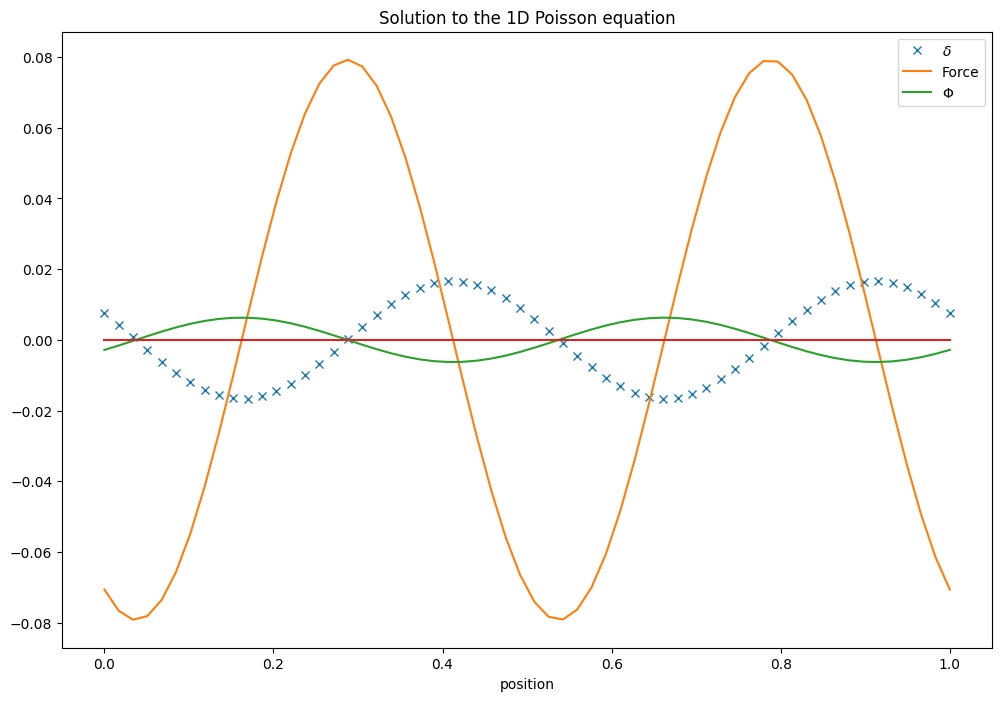

In [14]:
def density(x,k=2):
    phase = 1.1
    od = np.cos(k * 2 * math.pi * x + phase) # set up a periodic density
    d = od
#    dmean = integrate.simps(od,x)/1.   # mean density 
#    d = od - dmean # for periodic forces the mean of the right hand side needs to be zero
 
    return d

N=60
x = np.linspace(0,1,N) # uniform grid 
#x = np.insert(np.insert(sort(np.random.rand(N-2)),0,0),N-1,1) # non-uniform grid
d = density(x)
c = 1

F = -integrate.cumtrapz(c*d,x=x,initial=0)
F0 = -integrate.simps(F,x=x) # fix the force constant to keep momentum change=0
print('F(x=0) = ', F0)
F = F + F0

Phi = -integrate.cumtrapz(F,x,initial=0)
Phi = Phi - integrate.simps(Phi,x)/1.    # set potential to mean

plt.plot(x,d/N,'x',label="$\delta$");
plt.plot(x,F,label="Force");
plt.plot(x,Phi,label="$\Phi$");
plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation')
plt.legend();

### In class Exercise
    - Calculate the potential and force in and around a homogeneous sphere reusing the numerical integration and differentiation as in the example above. 
    - Have the sphere be at position x=0.4 and have a radius 0.025
    - What did you notice about our assumption of periodic boundaries? How does the mean density enter?
    - Plot it for the grid resolution 60 and 240
    - Discuss the solution


F(x=0) =  0.10041841004184161


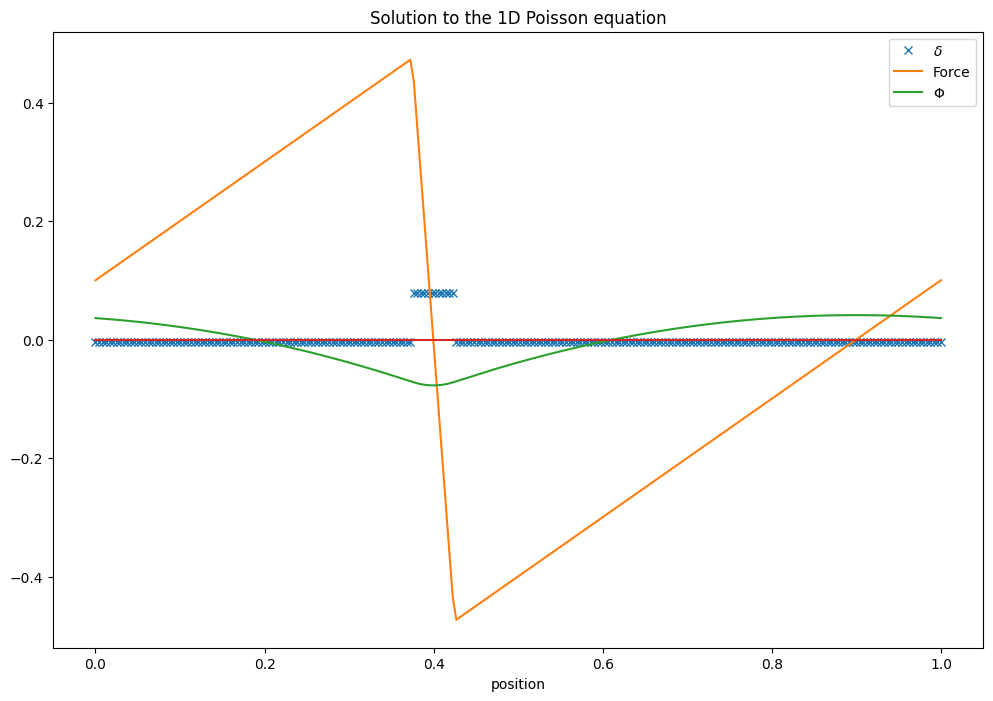

## Using relaxation

The trick we just used above is only possible in one dimensions. In two or more the Poisson equation is essentially always a boundary value problem. I.e. we need to specify the values of $\Phi$ on the boundary and the interate to find a convergent solution. We introduce this style of solving it here next but stay in one dimensions to keep things simple at first. So we start out by discretizing the Poisson equation using the [central difference](https://en.wikipedia.org/wiki/Numerical_differentiation) for the second derivative. 

$$
\frac{1}{h^2} \left( \Phi_{i+1} + \Phi_{i-1} - 2\Phi_i \right) = C\ D(x_i)
$$

where we took the liberty and drop the ~ symbols for $\tilde{\Phi}$ and $d\tilde{x}$ while still working in these dimensionless quantities.

This gives us an obvious solution strategy. We just solve for $\Phi_i$ and remember to specify boundary values on the left and right so that the resulting formula is always defined. I.e.

$$
\Phi_i = \frac{1}{2}\left( \Phi_{i+1} + \Phi_{i-1} - C\ D(x_i)\ h^2 \right) 
$$

For our first implementation we will assume periodic boundaries. 

The overdensity $D(x)$ will be defined at cell centers and similarly $\Phi$ is recorded at the same positions. 

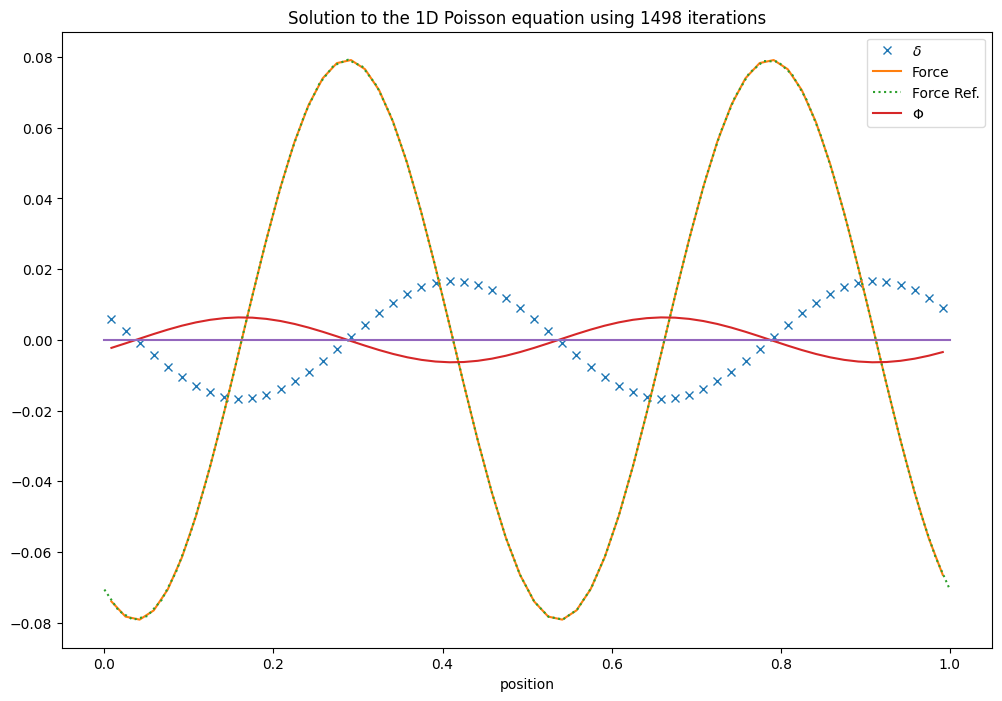

In [15]:
rx = (0.5+np.arange(N))/N
rd = density(rx)
dx = 1./N
Niter = 1498
ip1 = (np.arange(N) + 1) # define arrays that are the indeces i+1 and i-1
ip1[N-1] = 0
im1 = (np.arange(N) - 1)
rPhi = np.zeros(N,dtype=float)
for i in range(Niter):
    rPhi = (rPhi[ip1]+rPhi[im1] - c*rd*dx**2)/2.

rF = -(rPhi[ip1]-rPhi[im1])/(2.*dx)
# show results
plt.plot(rx,rd/N,'x',label="$\delta$");
plt.plot(rx,rF,label="Force");
plt.plot(x,F,':', label="Force Ref.")
plt.plot(rx,rPhi,label="$\Phi$");
plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using '+str(Niter)+' iterations')
leg=plt.legend();
leg.get_frame().set_alpha(0.7)

Wow. That takes an enormous amount of iterations to converge. In particular if the solution has long wavelength components. This method is known an <b>Jacobi's iterative method</b>.

Ah yes. But we could use the update values as we march through. Perhaps that converges faster?

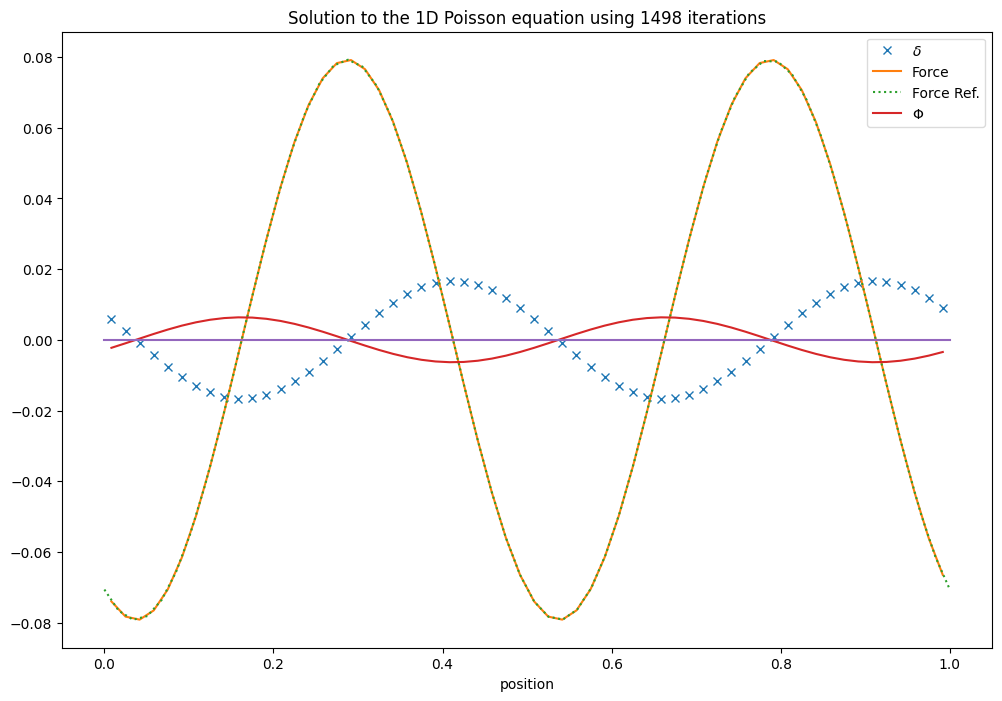

In [16]:
rx = (0.5+np.arange(N))/N
rd = density(rx)
dx = 1./N
Niter = 1498
ip1 = (np.arange(N) + 1) # define arrays that are the indeces i+1 and i-1
ip1[N-1] = 0
im1 = (np.arange(N) - 1)
rPhi = np.zeros(N,dtype=float)
for count in range(Niter):
#    rPhi = (rPhi[ip1]+rPhi[im1] - c*rd*dx**2)/2.
    for i in range(N):
        rPhi[i] = (rPhi[ip1[i]]+rPhi[im1[i]] - c*rd[i]*dx**2)/2.    
rF = -(rPhi[ip1]-rPhi[im1])/(2.*dx)

# show results
plt.plot(rx,rd/N,'x',label="$\delta$");
plt.plot(rx,rF,label="Force");
plt.plot(x,F,':', label="Force Ref.")
plt.plot(rx,rPhi,label="$\Phi$");

plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using '+str(Niter)+' iterations')
leg=plt.legend();
leg.get_frame().set_alpha(0.7)

That is indeed somewhat of an improvement. It is called the <b>Gauss Seidel</b> iteration. 

## Using Successive Over Relaxation

If we wouldn' change the values completely just on the neighbors but keep some information from previous steps we can weight the update. This is known as successive over-relaxation. 
$$
\Phi_i^{n+1} = (1-\omega)\ \Phi_i^n + \omega/2\ \left( \Phi^n_{i+1} + \Phi^n_{i-1} - c h^2 D \right),
$$
first for $i=0,2,4,\cdots$ and then for $i=1,3,5,\cdots$. It is the same number of operations as before but does converge somewhat quicker. 

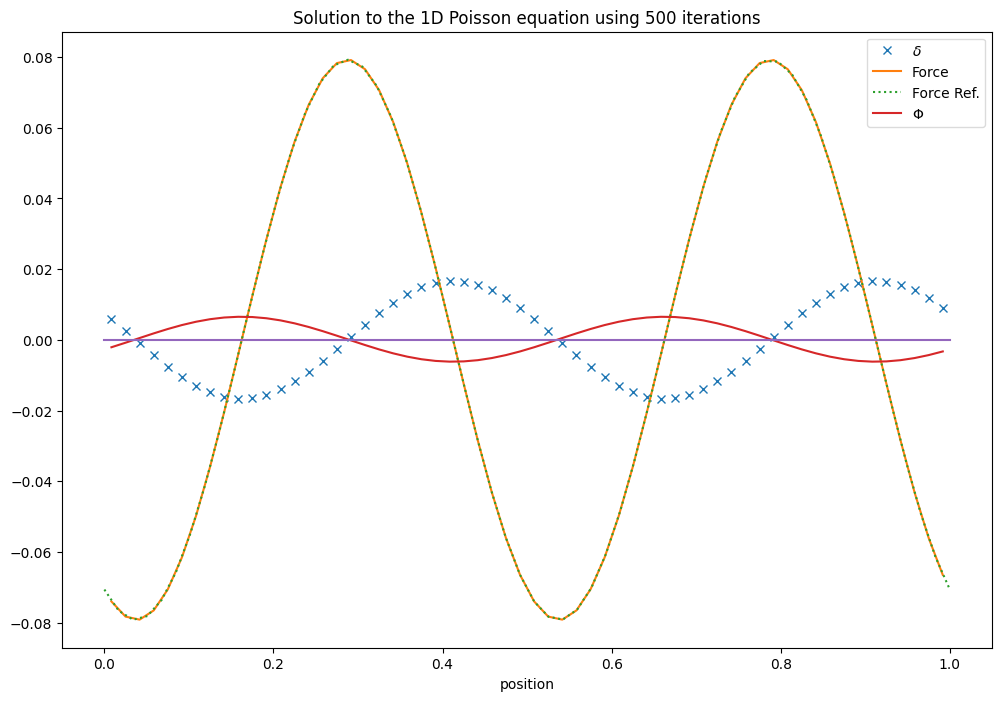

In [17]:
srx = (0.5+np.arange(N))/N
srd = density(x)
dx = 1./N
Niter = 500
ip1 = (np.arange(N) + 1) # define arrays that are the indeces i+1 and i-1
ip1[N-1] = 0
im1 = (np.arange(N) - 1)
srPhi = np.zeros(N,dtype=float)
w = 1.8
for count in range(Niter):
    for i in range(N):
        sigma = srPhi[ip1[i]]+ srPhi[im1[i]]
        srPhi[i] = (1.-w)*srPhi[i] - w/2*(c*rd[i]*dx**2-sigma)

srF = -(srPhi[ip1]-srPhi[im1])/(2.*dx)

# show results

plt.plot(srx,rd/N,'x',label="$\delta$");
plt.plot(srx,srF,label="Force");
plt.plot(x,F,':', label="Force Ref.")
plt.plot(srx,srPhi,label="$\Phi$");

plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using '+str(Niter)+' iterations')
leg=plt.legend();
leg.get_frame().set_alpha(0.7)

Ok. This is better!  It, however, added another parameter which is left to the user to choose. It is only convergent in $ 0 < w < 2 $.

## Succesive Over-Relaxation with Red Black Ordering

There is a variant of <b>Gauss Seidel</b> and succesive over-relaxation that is known as <b>red-black</b> ordering. This realizes that even positions are only dependent on odd neighbors and odd ones only on even. So first updates the one half and then the other. We do our SOR update
$$
\Phi_i^{n+1} = (1-\omega)\ \Phi_i^N + \omega/2\ \left( \Phi^n_{i+1} + \Phi^n_{i-1} - c h^2 D \right),
$$
first for $i=0,2,4,\cdots$ and then for $i=1,3,5,\cdots$. It is the same number of operations as before but does converge somewhat quicker.

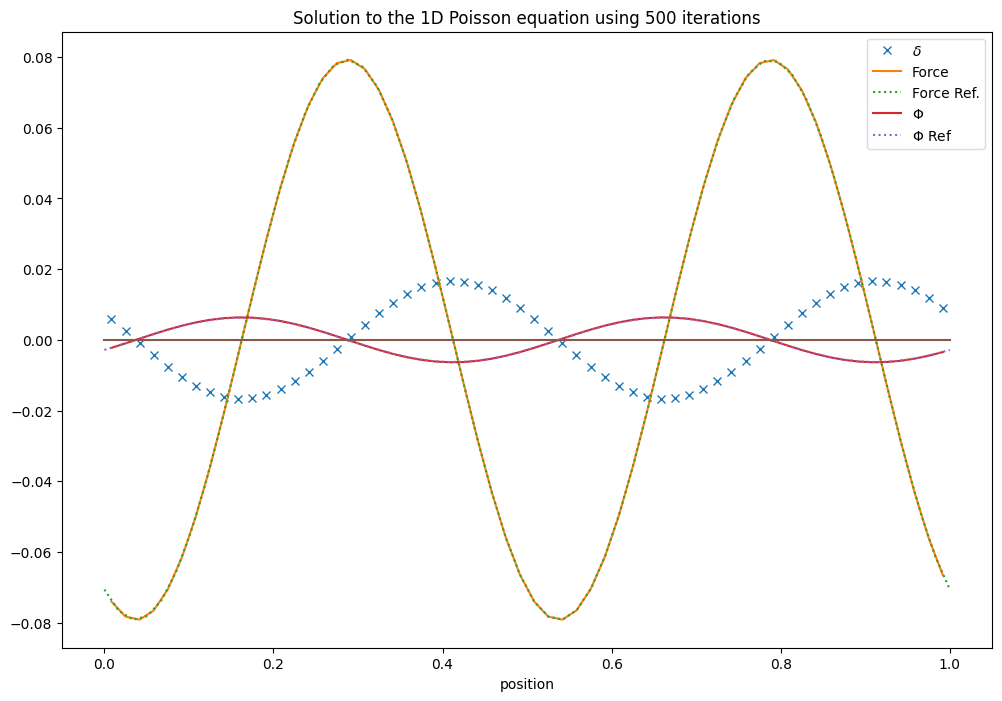

In [18]:
srx = (0.5+np.arange(N))/N
srd = density(srx)
dx = 1./N
Niter = 500
ip1 = (np.arange(N) + 1) # define arrays that are the indeces i+1 and i-1
ip1[N-1] = 0
im1 = (np.arange(N) - 1)
srPhi = np.zeros(N,dtype=float)
w = 1.8
for count in range(Niter):
    for i in range(0,N,2):
        sigma = srPhi[ip1[i]]+ srPhi[im1[i]]
        srPhi[i] = (1.-w)*srPhi[i] - w/2*(c*srd[i]*dx**2-sigma)
    for i in range(1,N,2):
        sigma = srPhi[ip1[i]]+ srPhi[im1[i]]
        srPhi[i] = (1.-w)*srPhi[i] - w/2*(c*srd[i]*dx**2-sigma)

srF = -(srPhi[ip1]-srPhi[im1])/(2.*dx)

# show results
plt.plot(srx,srd/N,'x',label="$\delta$");
plt.plot(srx,srF,label="Force");
plt.plot(x,F,':', label="Force Ref.")
plt.plot(srx,srPhi,label="$\Phi$");

plt.plot(x,Phi,':',label="$\Phi$ Ref");
plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using '+str(Niter)+' iterations')
leg=plt.legend();
leg.get_frame().set_alpha(0.7)

This is indeed a further improvement. 

## Recognizing this is a linear algebra problem

Our discretization we used in the relaxation method can also be written in matrix form:

$$ A\ \Phi = h^2 C\ D = 
\begin{pmatrix} 
-2 & 1 & 0 & \cdots & 0 & 0 & 1 \\\\ 
1 & -2 & 1 & 0 & \cdots & 0 & 0 \\\\ 
0 & 1 & -2 & 1 & 0 & \cdots & 0 \\\\ 
\vdots  & \vdots  & \ddots & \ddots & \ddots & \vdots & \vdots \\\\ 
0 & 0 & ... & 0 & 1 & -2 & 1 \\\\ 
1 & 0 & 0 & ... & 0 & 1 & -2 
\end{pmatrix}
\ 
\begin{pmatrix} 
\Phi_1 \\\\
\Phi_2 \\\\
\Phi_3 \\\\
\vdots \\\\
\Phi_{n-1} \\\\
\Phi_n 
\end{pmatrix}
= h^2 C\ 
\begin{pmatrix} 
D_1 \\\\
D_2 \\\\
D_3 \\\\
\vdots \\\\
D_{n-1} \\\\
D_n
\end{pmatrix}
$$

So in the relaxation technique we iterated until we got $\Phi$ to agree with this formula. 

So let us define this Matrix:

In [19]:
from scipy import linalg
#A = np.mat(np.zeros((N,N))) # mat turns the numpy array into an object of matrix type
A = (np.zeros((N,N))) # numpy array  of matrix type
for i in range(0,len(A)):
    A[i,i]=-2
    A[i,im1[i]] = 1
    A[i,ip1[i]] = 1
print(A.view())
print('Determinant of A is:', linalg.det(A))

[[-2.  1.  0. ...  0.  0.  1.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 1.  0.  0. ...  0.  1. -2.]]
Determinant of A is: 6.661338147751009e-14


and now invert it

In [20]:
Am1 = linalg.inv(A)
np.matmul(Am1,A)

array([[ 1.   , -0.125, -0.125, ...,  0.125, -0.125,  0.   ],
       [ 0.   ,  0.875,  0.   , ...,  0.125, -0.125,  0.   ],
       [ 0.   , -0.25 ,  1.   , ...,  0.125, -0.125,  0.   ],
       ...,
       [ 0.   ,  0.   , -0.375, ...,  1.125, -0.125, -0.25 ],
       [ 0.   ,  0.   , -0.25 , ...,  0.125,  0.875, -0.25 ],
       [ 0.   , -0.25 ,  0.   , ...,  0.125, -0.125,  0.75 ]])

This did not work ... It failed to correctly invert the matrix. I.e. we do not get identity matrix back when we multiply the original matrix and its supposed inverse. In hindsight we may have guessed that since the potential is not fixed up to a constant. So consequently the matrix has a determinant of zero and no unique solution is obtained. 

However, we can add one row in which we set a constant $\Phi$ value. I.e. 

$$ A\ \Phi = h^2 C\ D = 
\begin{pmatrix} 
-2 & 1 & 0 & \cdots & 0 & 0 & 1& 0  \\\\ 
1 & -2 & 1 & 0 & \cdots & 0 & 0& 0 \\\\ 
0 & 1 & -2 & 1 & 0 & \cdots & 0& 0 \\\\ 
\vdots  & \vdots  & \ddots & \ddots & \ddots & \vdots & \vdots \\\\ 
0 & 0 & ... & 0 & 1 & -2 & 1& 0 \\\\ 
1 & 0 & 0 & ... & 0 & 1 & -2& 0 \\\\
1 & 1 & 1 & ... & 1 & 1 & 1 & 0 
\end{pmatrix}
\ 
\begin{pmatrix} 
\Phi_1 \\\\
\Phi_2 \\\\
\Phi_3 \\\\
\vdots \\\\
\Phi_{n-1} \\\\
\Phi_n \\\\
\Phi_{n+1} 
\end{pmatrix}
= h^2 C\ 
\begin{pmatrix} 
D_1 \\\\
D_2 \\\\
D_3 \\\\
\vdots \\\\
D_{n-1} \\\\
D_n \\\\
0 
\end{pmatrix}
$$

Once we have the solution to $\Phi$ we throw away $\Phi_{n+1}$ and subtract the mean of the potential $\int_0^1 \Phi dx$ just by convention.

[[ 1.38777878e-16  4.94444444e-01  9.77777778e-01 ...  9.77777778e-01
   4.94444444e-01  1.11111111e-02]
 [-2.49800181e-16 -4.94444444e-01 -1.19410654e-15 ...  9.55555556e-01
   4.83333333e-01  1.11111111e-02]
 [-2.22044605e-16 -4.83333333e-01 -9.77777778e-01 ...  9.33333333e-01
   4.72222222e-01  1.11111111e-02]
 ...
 [ 5.55111512e-17  4.72222222e-01  9.33333333e-01 ... -9.77777778e-01
  -4.83333333e-01  1.11111111e-02]
 [ 2.77555756e-17  4.83333333e-01  9.55555556e-01 ...  3.33066907e-16
  -4.94444444e-01  1.11111111e-02]
 [ 1.00000000e+00  1.48333333e+00  1.95555556e+00 ...  1.00000000e+00
   5.05555556e-01  1.11111111e-02]]
Determinant of the input matrix is : 8100.0000000000355


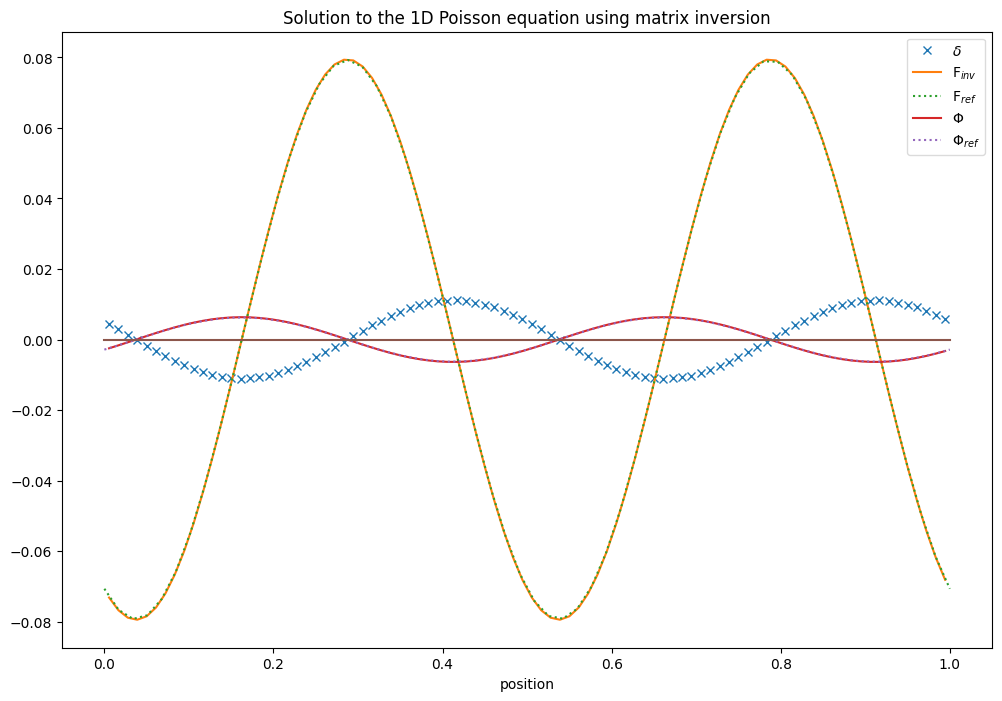

In [21]:
N=90
rx = (0.5+np.arange(N))/N
rd = density(rx)
dx = 1./N
A = (np.zeros((N+1,N+1))) # mat turns the numpy array into an object of matrix type
ip1 = (np.arange(N) + 1) # define arrays that are the indeces i+1 and i-1
ip1[N-1] = 0
im1 = (np.arange(N) - 1)
for i in range(0,len(A)-1):
    A[i,i]=-2
    A[i,im1[i]] = 1
    A[i,ip1[i]] = 1
A[N,:-1] = 1
#A[0,-1] = 0
#A[0,-2] = 1

rd = np.concatenate((rd, [0.]))

Am1 = linalg.inv(A)
iPhi = Am1* np.mat(rd).T *c # *dx**2 let multiply this small number later
iPhi = np.delete(np.ravel(iPhi), N)
iPhi *= dx**2
rd = np.delete(rd,N)

#iPhi = iPhi - integrate.simpson(iPhi,rx)/1 # subtract mean as convention
iF = -(iPhi[ip1]-iPhi[im1])/(2.*dx)

# show results
plt.plot(rx,rd/N,'x',label='$\delta$');
plt.plot(rx,iF, label='F$_{inv}$');
plt.plot(x,F,':',label='F$_{ref}$')
plt.plot(rx,iPhi,label="$\Phi$");
plt.plot(x,Phi,':', label='$\Phi_{ref}$')
plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using matrix inversion')
leg = plt.legend();
leg.get_frame().set_alpha(0.7)
print(Am1.view())
print('Determinant of the input matrix is :', linalg.det(A))

In [22]:
print('Determinant of A is:', linalg.det(A))

Determinant of A is: 8100.0000000000355


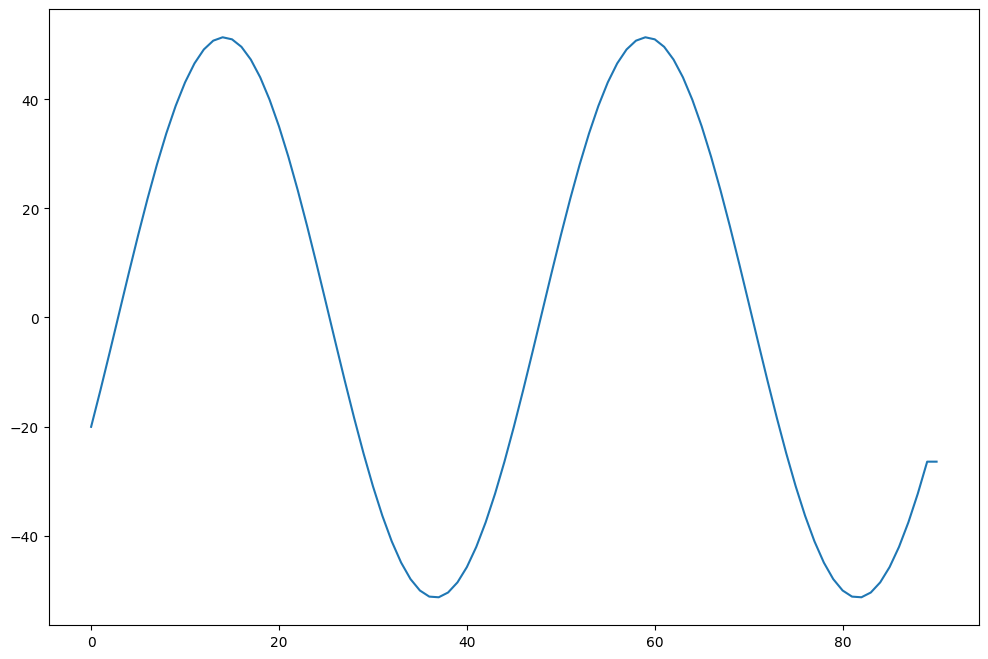

In [23]:
plt.plot(np.matmul(Am1[:,:-1], mat(rd).T))

So clearly all the matrix values are filled. This is now very similar to the $N^2$ operations we saw in the gravitational N-body problem. Every cell contibutes to the potential of every other cell and our matrix inversion gives the formula of how to do that. 

## Using Fast Fourier Transforms

Let us for a second though think of what would happen if we had the density and the potential given by their Fourier transforms. 
$$
\Phi(x) =  \int \phi(k)\ e^{2\pi\ ikx} dk, \ \ D(x) =  \int \delta(k)\ e^{2\pi\ ikx} dk
$$
If we enter this in our starting equation $\Delta \Phi=c\ D$ we find that
$$
-4\pi\ k^2\phi(k) = c\ \delta(k), \ \ \rightarrow \ \ \phi(k) = -\frac{c}{4\pi}\ \delta(k)/k^2.
$$
Oh fantastic. This means that if we Fourier transform the density, then multiply it with $-c/k^2$ in Fourier space we already get the Fourier transformed potential. If we then just do the inverse Fourier transform back to real space we should have the correct potential we were looking for! 

This may sound at first like a fairly complicated roundabaout way of getting at our problem. However, discrete Fourier transforms are only of complexity $log\ N \ \ N$ and some of the best optimized routines available on computers. So this can be an extraordinarily useful way of solving the Poisson equation in any dimension. 

This is so elegant we just have to try it. Fortunately python makes this easy for us since it comes with Fourier transforms and helper functions included. 

The conventions in numpy for the discrete Fourier transform are
$$
A_k = \sum_{m=0}^{N-1}\ a_m\ e^{-2\pi\ i\ m\ k/N}, \ \ k=0,1,...,n-2,n-1
$$
and the inverse transform is given by
$$
a_m = \frac{1}{N}\sum_{m=0}^{n-1}\ A_m\ e^{2\pi\ i\ m\ k/N}
$$
See the <A href="http://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft" target="_blank">FFT documentation</A> for more details.

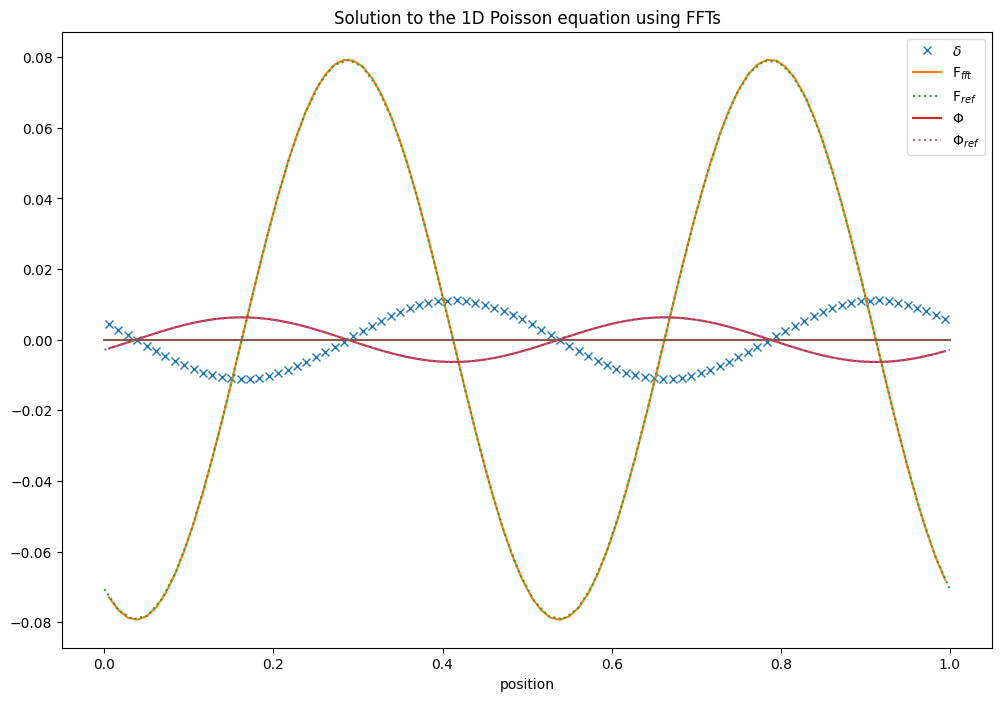

In [24]:
N=90
fx = (np.arange(N)+0.5)/N
fd = density(fx)
#fd=fd-fd.mean() # the mean has to be perfectly zero
dx = 1./N
lphi = np.zeros(N//2+1,dtype=complex)


delta = np.fft.rfft(fd)      # forward transform of density
k = 2*np.pi*np.fft.rfftfreq(len(fd),dx) # returns the wave numbers 
lphi[1:] = ((-c*delta[1:] /k[1:]**2))
lphi[0] = 0.  
fPhi = (np.fft.irfft(lphi)).real 


na = np.arange(N)
ip1 = na.take(np.arange(N)+1, axis=0, mode='wrap')
im1 = na.take(np.arange(N)-1, axis=0, mode='wrap')

fF = -(fPhi[ip1]-fPhi[im1])/(2.*dx)  # central difference
#fF = -np.gradient(fPhi,dx)

# show results

plt.plot(fx,fd/N,'x',label='$\delta$');
plt.plot(fx,fF, label='F$_{fft}$');
plt.plot(x,F,':',label='F$_{ref}$')
plt.plot(fx,fPhi,label="$\Phi$");
plt.plot(x,Phi,':', label='$\Phi_{ref}$')

plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using FFTs')
leg = plt.legend();
leg.get_frame().set_alpha(0.7)

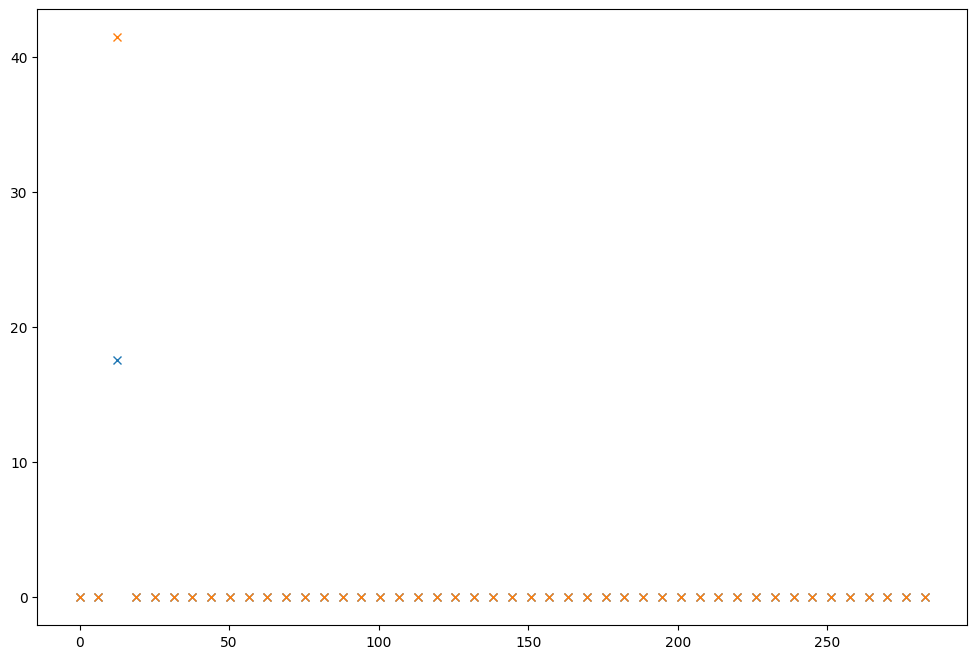

In [25]:
plot(k,delta.real,'x')
plot(k,delta.imag,'x');

# The Conjugate Gradient Method <img src="http://upload.wikimedia.org/wikipedia/commons/b/bf/Conjugate_gradient_illustration.svg" width="300" align="right"> 

The <a href="http://en.wikipedia.org/wiki/Conjugate_gradient_method">conjugate gradient method</a> is typically employed as an iterative approach to solving the linear equation
$$
\mathbf{A}\,\mathbf{x}=\mathbf{b}
$$
where <b>A</b> is a matrix and <b>x</b> and <b>b</b> are vectors. 

So we want to find a good approximate solution $\mathbf{x}_F$. 
We will want to start with a guess for $x_0$ and go through a number of iterations that we stop at $\mathbf{x}_F$ and call the intermediate results $\mathbf{x}_k$. 

For any guess $\mathbf{x}_k$ we can measure how far off from the correct solution we are
$$
\mathbf{r} = \mathbf{b} - \mathbf{A}\,\mathbf{x}.
$$ 
$\mathbf{r}$ is called the <b>residual</b> (or residue) at the $k$-th step. 

If we now think of this quadratic equation:
$$
f(\mathbf{x}) = \frac12 \mathbf{x}^\mathrm{T} \mathbf{A}\mathbf{x} - \mathbf{x}^\mathrm{T} \mathbf{b} , \quad \mathbf{x}\in\mathbf{R}^n. 
$$
we can see that $-\mathbf{r}$ is the gradient of $f$ at $\mathbf{x}_k$. So to find an $\mathbf{x}_F$ for which $\mathbf{r}\approx 0$ is equivalent to finding the minimum of $f$. There are methods which follow the steepest decent i.e. move along $\mathbf{r}$ to get towards the minimum. The trick in the conjugant gradient method is that it takes steps in orthogonal vectors to converge towards the minimum. The remarkable aspect of this algorithm is that it converges in at most $n$ steps where $\mathbf{A}$ is a $n\times n$ matrix.

So the key is to learn how to pick the search directions $\mathbf{p}_k$. The most common choice here is to find vectors ortho-normal to the last residue so our quantities only depend on the last step taken and not say on a large number of previous steps. 

For the first step we pick $\mathbf{p}_0=\mathbf{r}_0=\mathbf{b}-\mathbf{A\,x}_0$ as the search direction. 

Let us pick 

$$
\mathbf{x}_{k+1} = \mathbf{x}_k+\alpha_k\,\mathbf{p}_k,\ \ \ \  \alpha_k=\frac{\mathbf{r}^T_k \mathbf{r}_k}{\mathbf{p}_k^T\,\mathbf{A}\,\mathbf{p}_k}
$$

and 

$$\mathbf{p}_{k+1} = \mathbf{r}_{k+1} + \beta_k \, \mathbf{p}_k, \ \ \ \ \beta = \frac{\mathbf{r}_{k+1}^T\, \mathbf{r}_{k+1}}{ \mathbf{r}_{k}^T \, \mathbf{r}_{k}}
$$

i.e. a combination of the current residual and the previous search direction, for the next search direction. Different conjugate gradient methods differ typically in their choice of $\beta$ and of how many previous search directions are considered. Please also have a look at <a href="http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf">Jonathan Shewchuk's fantastic detailed description</a> of this method.


In [26]:
def ConGrad(A,b,tol,xinit=0,kmax=5000):
    '''Solve the linear problem A x = b
    A and b have to python matrices not arrays ! 
    '''
    r = b.copy()
    x = b.copy()
    x[:] = 0. # start with x=0 as a guess
    if type(xinit) != int:
       x = xinit
    k = 0
    r = b - A*x
    p = r.copy()
    rsold=ravel(r.T*r)[0]
    print(sqrt(rsold), tol)
    while (k==0 or ((sqrt(rsold) > tol) and (k < kmax))):
        Ap = A*p
        alphak = rsold/np.ravel(p.T*Ap)[0]
        x = x + alphak*p
        r = r - alphak*Ap
        rsnew = (ravel(r.T*r))[0]
        beta = rsnew/rsold
        p = r + beta*p
        k += 1
        rsold=rsnew
    print('iterated ', k, ' times to get to tolerance=', tol)
    if (k == kmax):
        print('reached max. iterations! ', kmax)
    return x

A = mat([[4.,1.001],[1.,3]])
b = mat([1.,2]).T
x = ConGrad(A,b,1e-10)
print('x=', ravel(x))

2.23606797749979 1e-10
iterated  6  times to get to tolerance= 1e-10
x= [0.09073552 0.63642149]


Double check the Answer. Is $\mathbf{A\,x}=\mathbf{b}$ ? 

In [27]:
A*x-b

matrix([[5.40056888e-12],
        [3.98747702e-12]])

step: 1  distance to minimum: 0.4880232063220932
step: 2  distance to minimum: 0.00019970168811959504
step: 3  distance to minimum: 1.33331579273615e-05
step: 4  distance to minimum: 1.604829311924901e-08
step: 5  distance to minimum: 5.532337408608809e-10
step: 6  distance to minimum: 1.519990794322524e-12
step: 7  distance to minimum: 2.675290464622487e-14
step: 8  distance to minimum: 1.5362729766613488e-16


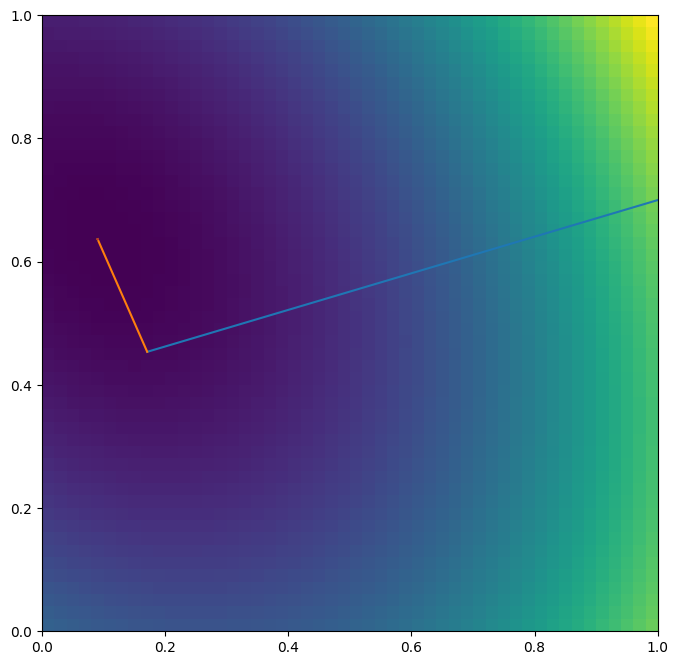

In [28]:
def f2(x,A,b):
    return ravel(0.5*x.T*A*x-x.T*b)[0]

xy = linspace(0.,1)
f = np.zeros((len(xy),len(xy)))
f[:] = 0.
for i in range(len(xy)):
    for j in range(len(xy)):
        x = mat([xy[i], 1.-xy[j]]).T
        f[i,j] = f2(x,A,b)
        
plt.imshow(f.T,extent=(xy.min(),xy.max(),xy.min(),xy.max()))

x=mat([1.,.7]).T
r = b.copy()-A*x
p = r.copy()
#x[:] = 0. # start with x=0 as a guess
k = 0
rsold=ravel(r.T*r)[0]
while ((k < 8)):
    Ap = A*p
    alphak = rsold/ravel(p.T*Ap)[0]
    xold = x
    x = x + alphak*p
    r = r - alphak*Ap
    rsnew = ravel(r.T*r)[0]
    beta = rsnew/rsold
    p = r + beta*p
    k += 1
    rsold=rsnew
    print('step:', k, ' distance to minimum:',sqrt(rsnew))
    plt.plot([ravel(xold[0])[0], ravel(x[0])[0]], [ravel(xold[1])[0],ravel(x[1])[0]])


F(x=0) =  -0.07086437094928495
8.122607918947157 0.1
iterated  56  times to get to tolerance= 0.1
8.122607918947157 0.0001
iterated  65  times to get to tolerance= 0.0001
8.122607918947157 1e-05
iterated  65  times to get to tolerance= 1e-05
8.122607918947157 1e-07
iterated  65  times to get to tolerance= 1e-07


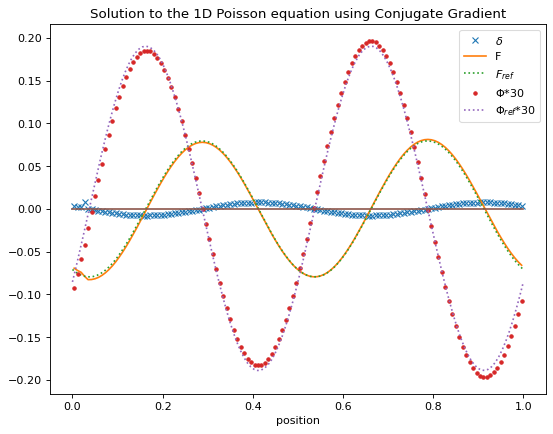

In [29]:
import scipy.integrate as integrate
C = 1
N=130
iPhi =0 

# reference solution
x = np.linspace(0.,1.,N) # uniform grid 
d = density(x)

F = -integrate.cumtrapz(C*d,x=x,initial=0)
F0 = -integrate.simps(F,x=x) # fix the force constant to keep momentum change=0
print('F(x=0) = ', F0)
F = F + F0
Phi = -integrate.cumtrapz(F,x,initial=0)
#Phi = Phi - integrate.simps(Phi,x)/1.    # set potential to mean
Phi = Phi - mean(Phi)

# now try with Conjugate Gradient
rx = (0.5+np.arange(N))/N
rd = density(rx)
rd[3] =1.
rd -= np.mean(rd)
dx = 1./N
A = mat(np.zeros((N,N)),dtype=double) # mat turns the numpy array into an object of matrix type
ip1 = (np.arange(N) + 1) # define arrays that are the indeces i+1 and i-1
ip1[N-1] = 0
im1 = (np.arange(N) - 1)
im1[0] = N-1
for i in range(0,N):
    A[i,i]=-2
    A[i,im1[i]] = 1
    A[i,ip1[i]] = 1
b = mat(rd,dtype=double).T*C # *dx**2  do this small number later

iPhi = ConGrad(A,b,1e-1)
iPhi = ConGrad(A,b,1e-4)
iPhi = ConGrad(A,b,1e-5)
iPhi = ConGrad(A,b,1e-7)

iPhi = iPhi*dx**2 # we solved without that factor
iPhi = iPhi - mean(iPhi) # convention: \bar{\Phi} = 0
iF = -(iPhi[ip1]-iPhi[im1])/(2.*dx) # force from central difference

# show results
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rx,rd/N,'x',label='$\delta$');
plt.plot(rx,iF,label='F');
plt.plot(x,F,':',label='$F_{ref}$')
plt.plot(rx,iPhi*30,'.',label='$\Phi$*30');
plt.plot(x,Phi*30,':',label='$\Phi_{ref}$*30')
plt.plot(np.zeros(2))
plt.xlabel('position')
plt.title('Solution to the 1D Poisson equation using Conjugate Gradient')
leg = plt.legend();
leg.get_frame().set_alpha(0.7)


### In class Exercise: 
- Let's see whether we can figure out how to use the [conjugate gradient method in scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html).
- Explore [Best least square solution](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq)

## The Laplace operator in spherical coordinates

The Laplace operator in spherical coordinates is:
$$
\begin{align}
\nabla^2 f &=& {1 \over r^2}{\partial \over \partial r}\!\left(r^2 {\partial f \over \partial r}\right)
  \!+\!{1 \over r^2\!\sin\theta}{\partial \over \partial \theta}\!\left(\sin\theta {\partial f \over \partial \theta}\right)
  \!+\!{1 \over r^2\!\sin^2\theta}{\partial^2 f \over \partial \varphi^2} 
= \\ 
& = &\left(\frac{\partial^2}{\partial r^2} + \frac{2}{r} \frac{\partial}{\partial r}\right)f \!+
{1 \over r^2\!\sin\theta}{\partial \over \partial \theta}\!\left(\sin\theta \frac{\partial}{\partial \theta}\right)f +\frac{1}{r^2\!\sin^2\theta}\frac{\partial^2}{\partial \varphi^2}f.
\end{align}
$$

Here we care only for the radial part:
$$
\nabla^2_r f =  {1 \over r^2}{\partial \over \partial r}\!\left(r^2 {\partial f \over \partial r}\right) = \left(\frac{\partial^2}{\partial r^2} + \frac{2}{r} \frac{\partial}{\partial r}\right)f
$$
and also make note of the gradient in radial direction:
$$
\nabla_r\ f = {\partial f \over \partial r}
$$
